# Causal thinking  ...
Ruiji

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

## Data Preparation

### Import ASHRAE Thermal Comfort Database 2

In [2]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

# Merge building metadata and measurement data
df_rawdata = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')

print('Total buildings:', len(df_rawdata.building_id.unique()))
print('Total records:', len(df_rawdata))

Total buildings: 809
Total records: 109033


/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_38968/1041017263.py:7: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_measurements = pd.read_csv(url_measurements)


### Clean outdoor air temperature data

In [4]:
# Merge two outdoor air temperature columns as a new column
df_rawdata.loc[:, 't_out_combined'] = df_rawdata.loc[:, 't_out_isd'].fillna(df_rawdata.loc[:, 't_out'])

# Remove the two outdoor air temperature columns
df_rawdata = df_rawdata.drop(columns=['t_out_isd', 't_out'])

### Filter out buildings that have required data

In [5]:
# Keep rows that simultaneously have data for all variables in cols 
def filter(df, cols):
    df_qualifed = df.dropna(subset=cols)
    print(f'Qualified buildings:', len(df_qualifed['building_id'].unique()))
    print(f'Qualified records:', len(df_qualifed))
    return df_qualifed

# Keep rows that simultaneously have data for all variables in cols
cols_1 = ['t_out_combined', 'set', 'top', 'thermal_sensation']
df_data = filter(df_rawdata, cols_1).copy()

Qualified buildings: 518
Qualified records: 26307


## Analysis on Single Building

In [6]:
# select one building and print out basic information
df_data_1bldg = df_data[df_data['building_id'] == 735]

print('field study period:', df_data_1bldg['timestamp'].min(), df_data_1bldg['timestamp'].max())
print('field study location:', df_data_1bldg.city.unique())
print('building type:', df_data_1bldg.building_type.unique())
print('cooling type:', df_data_1bldg.cooling_type.unique())
print('building occupants:', len(df_data_1bldg.subject_id.unique()))


field study period: 2015-04-13T00:00:00Z 2015-05-05T00:00:00Z
field study location: ['kuala lumpur']
building type: ['office']
cooling type: ['air conditioned']
building occupants: 1


### Approach (a)

/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_38968/1562816851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['timestamp'] = pd.to_datetime(df_data_1bldg['timestamp'])
/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_38968/1562816851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg[ 'days_since_start'] = (df_data_1bldg['timestamp'] - df_data_1bldg['timestamp'].min()).dt.days


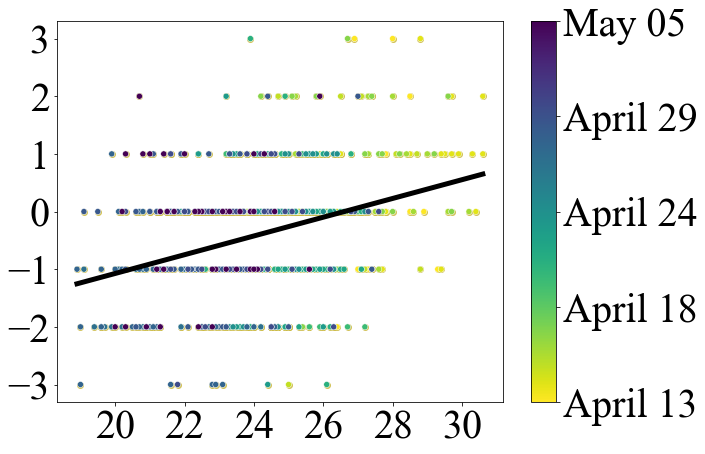

                            OLS Regression Results                            
Dep. Variable:      thermal_sensation   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     73.93
Date:                Mon, 06 May 2024   Prob (F-statistic):           6.48e-17
Time:                        16:27:19   Log-Likelihood:                -914.11
No. Observations:                 628   AIC:                             1832.
Df Residuals:                     626   BIC:                             1841.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3274      0.461     -9.382      0.0

In [11]:
lm_result = smf.ols(formula='thermal_sensation ~ set', data=df_data_1bldg).fit()

# Prepare the DataFrame
df_data_1bldg['timestamp'] = pd.to_datetime(df_data_1bldg['timestamp'])
df_data_1bldg[ 'days_since_start'] = (df_data_1bldg['timestamp'] - df_data_1bldg['timestamp'].min()).dt.days

# Plotting
plt.figure(figsize=(10, 7))
sns.regplot(x='set', y='thermal_sensation', data=df_data_1bldg, scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black', 'linewidth': 5}, ci=None)
sns.scatterplot(x='set', y='thermal_sensation', data=df_data_1bldg, hue='days_since_start', palette='viridis_r')

# Select 5 evenly spaced dates
selected_dates = np.linspace(df_data_1bldg['days_since_start'].min(), df_data_1bldg['days_since_start'].max(), 5, endpoint=True)
selected_date_labels = [(df_data_1bldg['timestamp'].min() + pd.Timedelta(days=int(day))).strftime('%B %d') for day in selected_dates]

# Add colorbar with selected dates
norm = plt.Normalize(df_data_1bldg['days_since_start'].min(), df_data_1bldg['days_since_start'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, aspect=15)
cbar.set_ticks(selected_dates)
cbar.set_ticklabels(selected_date_labels)
cbar.ax.tick_params(labelsize=40)

# modify the x and y axis
plt.xlabel('', fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)
plt.xticks(fontsize=40)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=40)  # Set font size for y-axis tick labels
plt.grid(False)
plt.legend().remove()

# change the font to sen-serif Times new roman
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('fig/Bldg_neutral_a.pdf', format='pdf', bbox_inches='tight')
plt.show()

# statistical anayalsis summary
print(lm_result.summary())
print("******************************************************************************")

# check whether the correaltion (slope) is significant
if lm_result.pvalues['set'] < 0.05:
    a = lm_result.params['set']
    b = lm_result.params['Intercept']
    temp_n = -b / a
    temp_up = (0.85-b)/a
    temp_low = (-0.85-b)/a
    print('Neutral temperature: {:.1f}'.format(temp_n), chr(176),'C', sep='')
    print('Comfort Zone: {:.1f}'.format(temp_low), chr(176),'C to {:.1f}'.format(temp_up), chr(176),'C', sep='')
else:
    print('The slope is not significant, p value: {:.2f}'.format(lm_result.pvalues['set']))

### Approach (b)

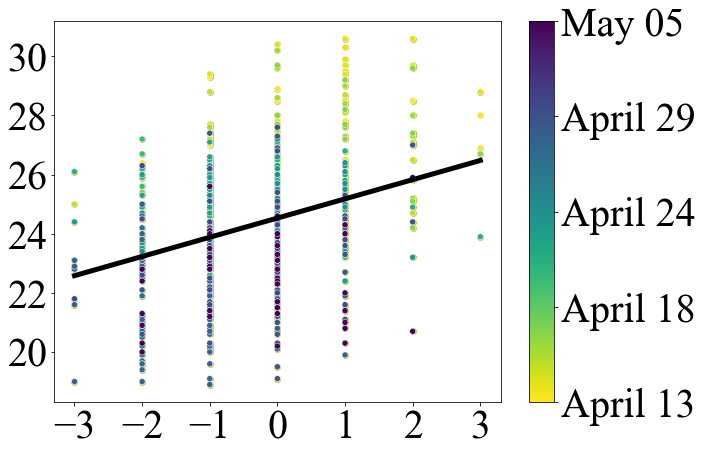

                            OLS Regression Results                            
Dep. Variable:                    set   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     73.93
Date:                Mon, 06 May 2024   Prob (F-statistic):           6.48e-17
Time:                        16:28:09   Log-Likelihood:                -1348.8
No. Observations:                 628   AIC:                             2702.
Df Residuals:                     626   BIC:                             2710.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            24.5296      0.08

In [14]:
lm_result = smf.ols(formula='set ~ thermal_sensation', data=df_data_1bldg).fit()

# Plotting
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='set', data=df_data_1bldg, scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black', 'linewidth': 5}, ci=None)
sns.scatterplot(x='thermal_sensation', y='set', data=df_data_1bldg, hue='days_since_start', palette='viridis_r')

# Select 5 evenly spaced dates
selected_dates = np.linspace(df_data_1bldg['days_since_start'].min(), df_data_1bldg['days_since_start'].max(), 5, endpoint=True)
selected_date_labels = [(df_data_1bldg['timestamp'].min() + pd.Timedelta(days=int(day))).strftime('%B %d') for day in selected_dates]

# Add colorbar with selected dates
norm = plt.Normalize(df_data_1bldg['days_since_start'].min(), df_data_1bldg['days_since_start'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, aspect=15)
cbar.set_ticks(selected_dates)
cbar.set_ticklabels(selected_date_labels)
cbar.ax.tick_params(labelsize=40)

# modify the x and y axis
plt.xlabel('', fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)
plt.xticks(fontsize=40)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=40)  # Set font size for y-axis tick labels
plt.grid(False)
plt.legend().remove()

# plt.title('Regress thermal sensation votes on indoor temperature')
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('fig/Bldg_neutral_b.pdf', format='pdf', bbox_inches='tight')
plt.show()

# statistical anayalsis summary
print(lm_result.summary())
print("******************************************************************************")

# check whether the correaltion (slope) is significant
if lm_result.pvalues['thermal_sensation'] < 0.05:
    a = lm_result.params['thermal_sensation']
    b = lm_result.params['Intercept']
    temp_n = b
    temp_up = 0.85*a + b
    temp_low = (-0.85)*a + b
    print('Neutral temperature: {:.1f}'.format(temp_n), chr(176),'C', sep='')
    print('Comfort Zone: {:.1f}'.format(temp_low), chr(176),'C to {:.1f}'.format(temp_up), chr(176),'C', sep='')
else:
    print('The slope is not significant, p value: {:.2f}'.format(lm_result.pvalues['set']))